이전 기온 예측 프로젝트에선 모델은 Dense층을 쌓아 구현한 DNN으로 학습, 예측을 진행하였다.  
그런데 기상 데이터는 시퀀스 데이터로 시계열성을 갖는다.  
시계열 데이터에 적합한 모델인 RNN과 LSTM을 이용하여 학습, 예측을 비교하여 성능을 비교해보려한다.  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 데이터 불러오기
data = pd.read_csv('OBS_ASOS_DD_20210104225316.csv', encoding = 'cp949')  # 2020-01-01~2010-01-01
data1 = pd.read_csv('OBS_ASOS_DD_20210104225407.csv', encoding = 'cp949') # 2010-01-02~2020-01-02
data2 = pd.read_csv('OBS_ASOS_DD_20210104225442.csv', encoding = 'cp949') # 2020-01-03~2021-01-03

data = pd.concat([data,data1,data2],axis=0).reset_index().drop('index',axis=1)

In [4]:
print('데이터 개수 =', len(data))
print('데이터 컬럼 개수 =', len(data.columns))
data.columns

데이터 개수 = 7674
데이터 컬럼 개수 = 62


Index(['지점', '지점명', '일시', '평균기온(°C)', '최저기온(°C)', '최저기온 시각(hhmi)', '최고기온(°C)',
       '최고기온 시각(hhmi)', '강수 계속시간(hr)', '10분 최다 강수량(mm)', '10분 최다강수량 시각(hhmi)',
       '1시간 최다강수량(mm)', '1시간 최다 강수량 시각(hhmi)', '일강수량(mm)', '최대 순간 풍속(m/s)',
       '최대 순간 풍속 풍향(16방위)', '최대 순간풍속 시각(hhmi)', '최대 풍속(m/s)', '최대 풍속 풍향(16방위)',
       '최대 풍속 시각(hhmi)', '평균 풍속(m/s)', '풍정합(100m)', '최다풍향(16방위)',
       '평균 이슬점온도(°C)', '최소 상대습도(%)', '최소 상대습도 시각(hhmi)', '평균 상대습도(%)',
       '평균 증기압(hPa)', '평균 현지기압(hPa)', '최고 해면기압(hPa)', '최고 해면기압 시각(hhmi)',
       '최저 해면기압(hPa)', '최저 해면기압 시각(hhmi)', '평균 해면기압(hPa)', '가조시간(hr)',
       '합계 일조시간(hr)', '1시간 최다일사 시각(hhmi)', '1시간 최다일사량(MJ/m2)', '합계 일사량(MJ/m2)',
       '일 최심신적설(cm)', '일 최심신적설 시각(hhmi)', '일 최심적설(cm)', '일 최심적설 시각(hhmi)',
       '합계 3시간 신적설(cm)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', '평균 지면온도(°C)',
       '최저 초상온도(°C)', '평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)',
       '평균 20cm 지중온도(°C)', '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)',
       '1.0m 지중온도(°C)', '1.5m 지중온도(°C)', '3.0m 지중온

In [6]:
# 데이터 전처리  
# 강수, 적설량과 관련된 변수는 0으로 결측 채우기  
rain_col = [i for i in data.columns if '강수' in i]
snow_col = [i for i in data.columns if '적설' in i]

data[rain_col+snow_col] = data[rain_col+snow_col].fillna(0)

data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']] = data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']].fillna(0)

# 사용하지 않는 컬럼 버리기
data = data.drop(['기사','강수 계속시간(hr)','10분 최다 강수량(mm)'],axis=1)

time_col=[i for i in data.columns if '시각' in i]
data = data.drop(time_col, axis=1)

data = data.drop(['지점','지점명'], axis=1)

# 시간 순서로 학습시키기 위해 시간 정렬
data = data.sort_values('일시').interpolate(method='linear')

# 보간 후 결측치 없음을 확인
print('결측치 개수 =',data.isna().sum().sum())

결측치 개수 = 0


In [7]:
# 라벨값 설정
data['Y'] = data['평균기온(°C)'].shift(-2)
data = data.dropna()

# train, valid, test dataset 분리
train = data[data['일시']<'2013-01-01']
valid = data[data['일시']>='2013-01-01']
valid = valid[valid['일시']<'2017-01-01']
test = data[data['일시']>='2017-01-01']
print(' train set:',len(train),'개\n',
      'valid set:',len(valid),'개\n',
      'test set',len(test),'개')

# X와 Y분리
trainX,trainY = train.drop(['일시','Y'],axis=1), train['Y']
validX,validY = valid.drop(['일시','Y'],axis=1), valid['Y']
testX,testY = test.drop(['일시','Y'],axis=1), test['Y']

 train set: 4749 개
 valid set: 1461 개
 test set 1462 개


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


#### DNN

In [10]:
inputs_1 = tf.keras.Input(shape=44)
dense = tf.keras.layers.Dense(50)(inputs_1)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
output = tf.keras.layers.Dense(1)(dense)

DNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

DNN.compile(loss='mse', optimizer=optimizer)
DNN.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2250      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 9,951
Trainable params: 9,951
Non-trainable params: 0
_________________________________________________________

Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4744/4749 [============================>.] - ETA: 0s - loss: 313.4961
Epoch 00001: val_loss improved from inf to 16.63447, saving model to checkpoint.keras
4749/4749 [==============================] - 7s 2ms/sample - loss: 313.1976 - val_loss: 16.6345
Epoch 2/200
4716/4749 [============================>.] - ETA: 0s - loss: 26.2729
Epoch 00002: val_loss did not improve from 16.63447
4749/4749 [==============================] - 7s 1ms/sample - loss: 26.2347 - val_loss: 18.3862
Epoch 3/200
4742/4749 [============================>.] - ETA: 0s - loss: 31.1195
Epoch 00003: val_loss improved from 16.63447 to 11.81849, saving model to checkpoint.keras

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4749/4749 [==============================] - 7s 1ms/sample - loss: 31.0794 - val_loss: 11.8185
Epoch 4/200
4748/4749 [============================>.] - ETA: 0s - loss: 10.3691
Epoch 00004: val_loss improved

Epoch 34/200
4743/4749 [============================>.] - ETA: 0s - loss: 9.2872
Epoch 00034: val_loss did not improve from 8.97261
4749/4749 [==============================] - 7s 1ms/sample - loss: 9.2879 - val_loss: 8.9888
Epoch 35/200
4715/4749 [============================>.] - ETA: 0s - loss: 9.2618
Epoch 00035: val_loss did not improve from 8.97261
4749/4749 [==============================] - 7s 1ms/sample - loss: 9.2875 - val_loss: 8.9868
Epoch 36/200
4732/4749 [============================>.] - ETA: 0s - loss: 9.2995
Epoch 00036: val_loss did not improve from 8.97261
4749/4749 [==============================] - 7s 1ms/sample - loss: 9.2870 - val_loss: 8.9850
Epoch 37/200
4746/4749 [============================>.] - ETA: 0s - loss: 9.2917
Epoch 00037: val_loss did not improve from 8.97261
4749/4749 [==============================] - 7s 1ms/sample - loss: 9.2866 - val_loss: 8.9873


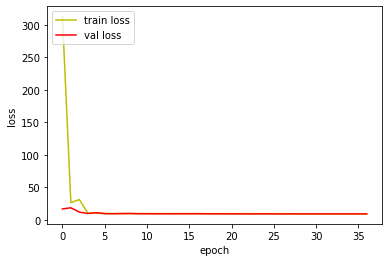

In [16]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = DNN.fit(trainX,trainY, validation_data=(validX, validY), 
                 epochs = 200, batch_size=1, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

#### RNN  
RNN의 경우 입력 데이터 형태가 3차원이 되어야 한다.  
input shape = (Batch size, timesteps, input_dim)  
Bath size는 한번에 학습되는 데이터 개수  
timesteps는 데이터의 시퀀스 길이  
input_dim은 feature 개수  
이다  

In [33]:
inputs_1 = tf.keras.Input(shape=(1,44))
rnn = tf.keras.layers.SimpleRNN(50, return_sequences=True)(inputs_1)
rnn = tf.keras.layers.SimpleRNN(50, return_sequences=False)(rnn)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 1, 44)]           0         
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 1, 50)             4750      
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 9,851
Trainable params: 9,851
Non-trainable params: 0
_________________________________________________________________


Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4300/4749 [==========================>...] - ETA: 0s - loss: 186.1701
Epoch 00001: val_loss improved from inf to 133.62165, saving model to checkpoint.keras
4749/4749 [==============================] - 1s 258us/sample - loss: 180.6299 - val_loss: 133.6217
Epoch 2/200
4000/4749 [========================>.....] - ETA: 0s - loss: 117.0861
Epoch 00002: val_loss improved from 133.62165 to 118.68432, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 33us/sample - loss: 116.0907 - val_loss: 118.6843
Epoch 3/200
4300/4749 [==========================>...] - ETA: 0s - loss: 108.6230
Epoch 00003: val_loss improved from 118.68432 to 114.04115, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 32us/sample - loss: 109.3542 - val_loss: 114.0412
Epoch 4/200
4100/4749 [========================>.....] - ETA: 0s - loss: 106.0920
Epoch 00004: val_loss improved from 114.04115 to 108.057

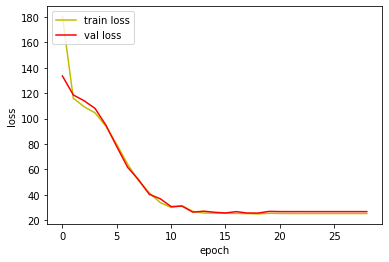

In [34]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(trainX.values.reshape(-1,1,44),trainY, validation_data=(validX.values.reshape(-1,1,44), validY), 
                 epochs = 200, batch_size=100, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

#### LSTM  
LSTM도 RNN과 같이 입력 데이터 형태가 3차원이 되어야 한다.  
input shape = (Batch size, timesteps, input_dim)  

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 1, 44)]           0         
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 1, 50)             4750      
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, 50)                5050      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 9,851
Trainable params: 9,851
Non-trainable params: 0
_________________________________________________________________
Train on 4749 samples, validate on 1461 samples
Epoch 1/200
2700/4749 [================>.............] - ETA: 0s - loss: 183.0875 
Epoch 00001: val_loss improved from inf to 133.35520, saving model to checkpoint.keras
4749/4749 [=========================

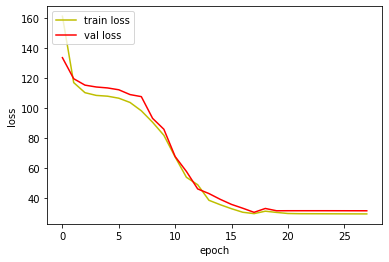

In [39]:
inputs_1 = tf.keras.Input(shape=(1,44))
lstm = tf.keras.layers.LSTM(50, return_sequences=True)(inputs_1)
lstm = tf.keras.layers.LSTM(50, return_sequences=False)(lstm)
output = tf.keras.layers.Dense(1)(lstm)

LSTM = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

LSTM.compile(loss='mse', optimizer=optimizer)
LSTM.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = LSTM.fit(trainX.values.reshape(-1,1,44),trainY, validation_data=(validX.values.reshape(-1,1,44), validY), 
                 epochs = 200, batch_size=100, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

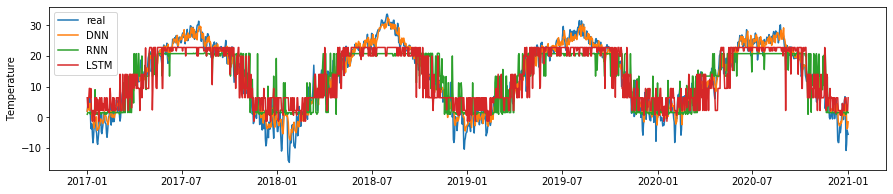

In [40]:
time = pd.to_datetime(test['일시'])

pred_DNN = DNN.predict(testX)
pred_RNN = RNN.predict(testX.values.reshape(-1,1,44))
pred_LSTM = LSTM.predict(testX.values.reshape(-1,1,44))


plt.figure(figsize = (15,3))
plt.plot(time,testY.reset_index()['Y'])
plt.plot(time,pred_DNN)
plt.plot(time,pred_RNN)
plt.plot(time,pred_LSTM)

plt.ylabel('Temperature')
plt.legend(['real','DNN','RNN','LSTM'])

아니 결과 무슨일이야ㅠㅠㅠㅠㅠ  
RNN, LSTM 모두 같은 결과  
최적화를 안해서 안좋은 결과가 나오는거 겠지만  
둘이 비슷한 형태로 예측된다는건 이유가 있을 것 같다  
찾아보자  